# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Xro0QiR.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [102]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Task 1: Simple LangGraph RAG

Now that we have our dependencies set-up - let's create a simple RAG graph that works over our Loan PDFs from previous sessions.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [103]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

Now we can chunk it down to size!

In [104]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

Now we've successfully split our single PDF into...

In [105]:
len(loan_knowledge_chunks)

375

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [106]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [107]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Let's make sure we can access it as a retriever.

In [108]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [109]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [110]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single graph - and we're off!

In [111]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

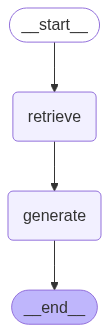

In [112]:
rag_graph

Let's test this out and make sure it works.

In [113]:
rag_graph.invoke({"question" : "What is the maximum loan amount?"})

{'question': 'What is the maximum loan amount?',
 'context': [Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 69, '_id': '1f9b56470c614228a2e66e0535176b1c', '_collection_name': '1e9d8779a25d472d88dc2e0e6dd81a8e'}, page_content='program. Therefore, the maximum loan amount the student may receive for the program at School B (for the\nabbreviated loan period and any subsequent loan period combined) is a total of $1,815, not more than $1,155 of\nwhich may be subsidized (the prorated loan limits for the program). If the student receives the maximum prorated\nloan limit for the 

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

##### ✅ Answer:

In [114]:
# Dynamic Arxiv Paper Fetching Implementation with Vector Store Only - USING TOOLBELT SYNTAX

# Import necessary classes
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

# Define the State class
class State(TypedDict):
    question: str
    context: list[Document]
    response: str

# 1. Create Tool Belt with Arxiv Tool (TOOLBELT SYNTAX)
from langchain_community.tools.arxiv.tool import ArxivQueryRun

# Create the tool belt (TOOLBELT SYNTAX)
arxiv_tool = ArxivQueryRun()
tool_belt = [arxiv_tool]

# 2. Set up the model with tool belt (TOOLBELT SYNTAX)
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
model = model.bind_tools(tool_belt)

# 3. Create Vector Store Based RAG Chain using tool belt
def create_dynamic_vectorstore(query: str):
    """Create a vector store from dynamically fetched papers using tool belt"""
    # Use the tool belt to fetch papers (TOOLBELT SYNTAX)
    papers_content = arxiv_tool.invoke(query)
    
    # Convert the papers content into Document objects
    documents = []
    if papers_content:
        # Split the content into manageable chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=750,
            chunk_overlap=0,
            length_function=tiktoken_len,
        )
        
        # Create Document objects from the papers content
        paper_chunks = text_splitter.split_text(papers_content)
        documents = [Document(page_content=chunk) for chunk in paper_chunks]
    
    return documents

def vector_retrieve(state: State) -> State:
    """Retrieve papers using dynamic vector store with tool belt"""
    question = state["question"]
    
    # Create dynamic retriever using tool belt
    documents = create_dynamic_vectorstore(question)
    
    if documents:
        # Create vector store
        vectorstore = Qdrant.from_documents(
            documents=documents,
            embedding=embedding_model,
            location=":memory:"
        )
        retriever = vectorstore.as_retriever()
        retrieved_docs = retriever.invoke(question, config={"k": 5})
        return {"context": retrieved_docs}
    else:
        return {"context": []}

def vector_generate(state: State) -> State:
    """Generate response using the vector store retrieved context"""
    generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
    
    # Better context processing
    if state["context"]:
        # Combine all context with better formatting
        context_parts = []
        for i, doc in enumerate(state["context"], 1):
            context_parts.append(f"Document {i}:\n{doc.page_content}")
        context_text = "\n\n---\n\n".join(context_parts)
    else:
        context_text = "No relevant papers found."
    
    response = generator_chain.invoke({
        "query": state["question"], 
        "context": context_text
    })
    return {"response": response}

# 4. Build Vector Store RAG Graph (same syntax as before)
vector_graph_builder = StateGraph(State)
vector_graph_builder = vector_graph_builder.add_sequence([vector_retrieve, vector_generate])
vector_graph_builder.add_edge(START, "vector_retrieve")
vector_rag_graph = vector_graph_builder.compile()

In [115]:
# Test with different research topics
topics = [
    "machine learning transformers",
    "natural language processing",
    "computer vision deep learning",
    "reinforcement learning",
    "quantum computing"
]

for topic in topics:
    result = vector_rag_graph.invoke({"question": f"What are the latest developments in {topic}?"})
    print(f"\n=== {topic.upper()} ===")
    print(result["response"][:500] + "...")  # Show first 500 characters


=== MACHINE LEARNING TRANSFORMERS ===
The latest developments in machine learning transformers, based on the provided context, include:

1. Advances in embedding arbitrary metric space data using small probabilistic transformer models. Specifically, a study showed that probabilistic transformers with depth around \( n \log(n) \) and width about \( n^2 \) can bi-Hölder embed any \( n \)-point dataset from a metric space with low distortion, avoiding the curse of dimensionality. They also provide probabilistic bi-Lipschitz guarantees,...

=== NATURAL LANGUAGE PROCESSING ===
The provided context mentions a comprehensive review on sentiment analysis, which is a significant area within natural language processing (NLP). Specifically, the review discusses recent advancements in sentiment analysis, including the use of machine learning, deep learning, lexicon-based approaches, and NLP techniques to identify and categorize opinions expressed in text across social media platforms. It also high

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [116]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [117]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [118]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> AgentExecutor:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    
    # FIXED: Use 'messages' to match LangGraph state structure
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [119]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching Loan Policy

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic, in this case: Loans!

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [120]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [121]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about student loan policies"""
  return rag_graph.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [122]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [123]:
llm = ChatOpenAI(model="gpt-4o-mini")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

Looking at the notebook, **Question #1** asks:

> Why is a "powerful" LLM important for this use-case?
> 
> What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

##### ✅ Answer:

A "powerful" LLM is important for this use-case because the agents must perform several **complex reasoning tasks**:

### 1. **Tool Selection and Reasoning**
The agents need to:
- **Analyze user queries** to understand what information is needed
- **Choose the right tool** from multiple options (Tavily search vs RAG retrieval)
- **Determine when to use each tool** based on the query type
- **Combine information** from multiple sources

### 2. **Context Understanding and Synthesis**
The agents must:
- **Understand the conversation flow** and maintain context
- **Synthesize information** from different sources (web search + loan documents)
- **Identify relevant vs irrelevant information**
- **Connect related concepts** across different documents

### 3. **Routing and Decision Making**
The supervisor agents need to:
- **Analyze the current state** of the conversation
- **Determine which agent should act next** based on the task requirements
- **Decide when the task is complete** (FINISH vs continue)
- **Understand task dependencies** (research before writing)

### 4. **Multi-Step Problem Solving**
The agents perform:
- **Decomposition**: Breaking complex queries into sub-tasks
- **Sequencing**: Determining the order of operations
- **Integration**: Combining results from different agents
- **Quality assessment**: Evaluating if the response is complete

### 5. **Domain-Specific Reasoning**
For loan policy questions, agents must:
- **Understand financial terminology**
- **Interpret policy documents**
- **Apply rules and regulations**
- **Provide accurate, compliant information**

## Why Reasoning Capability is a Limiter

If the LLM lacks reasoning capability, it might:
- ❌ **Choose wrong tools** (search when RAG is needed)
- ❌ **Miss important context** from previous messages
- ❌ **Make poor routing decisions** (wrong agent selection)
- ❌ **Provide incomplete answers** without proper synthesis
- ❌ **Fail to understand complex queries** requiring multi-step reasoning

## Example of Complex Reasoning Required

For a query like: *"What are the loan limits for graduate students and how do they compare to undergraduate limits?"*

The agent must:
1. **Decompose** the question into sub-questions
2. **Search** for graduate loan information
3. **Search** for undergraduate loan information  
4. **Compare** the two sets of data
5. **Synthesize** a coherent comparison
6. **Route** to appropriate agents for each step

A less powerful LLM might struggle with this multi-step reasoning process, leading to incomplete or incorrect responses.

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [124]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [125]:
# Create agents with error checking
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research agent that helps find information about student loans."
)
if research_agent is None:
    print("❌ Research agent creation failed!")
    # Handle the error appropriately
research_node = functools.partial(agent_node, agent=research_agent, name="LoanRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [126]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, LoanRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "LoanRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [127]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("LoanRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [128]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("LoanRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "LoanRetriever": "LoanRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [129]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

#### Display Graph

In [130]:
import nest_asyncio
nest_asyncio.apply()

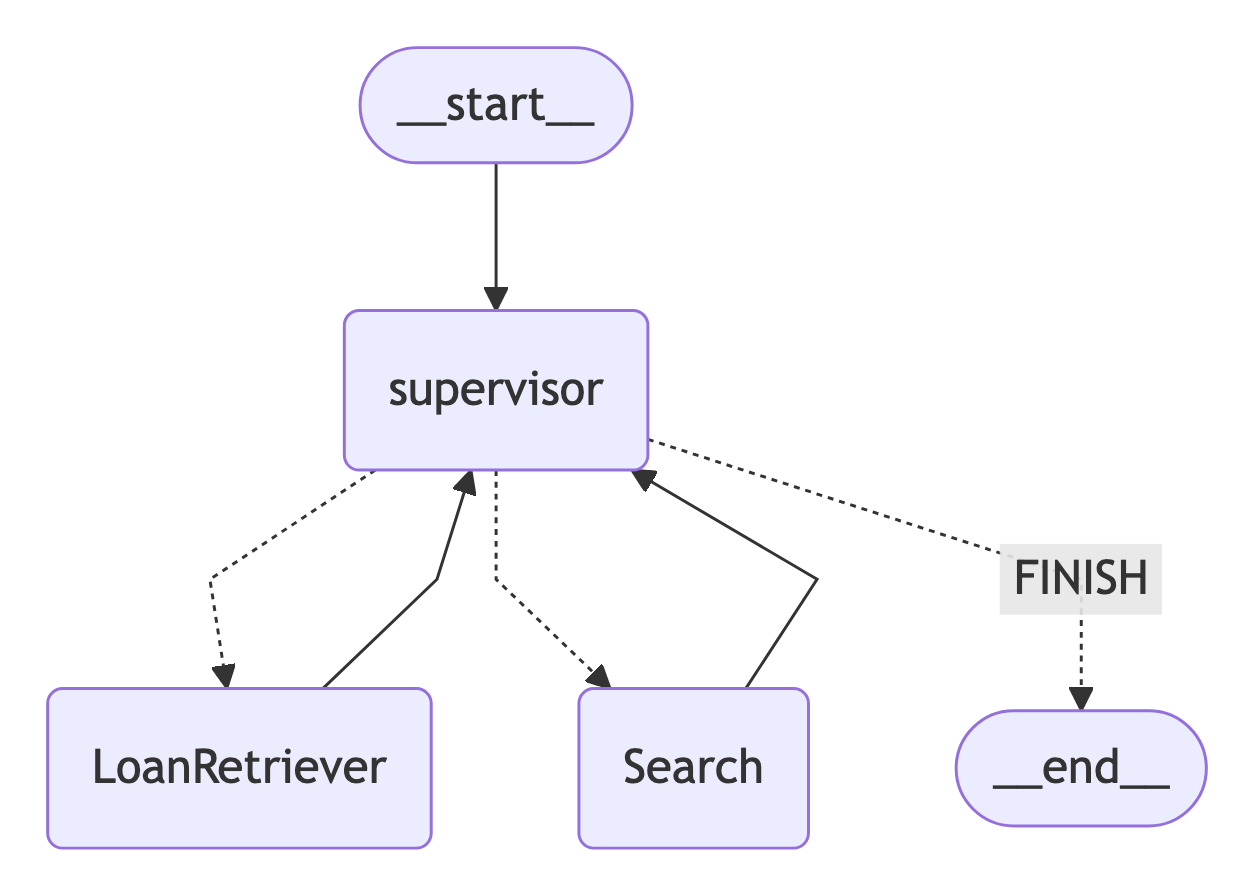

In [131]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [132]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [133]:
for s in research_chain.stream(
    "What is the maximum student loan in 2025?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'LoanRetriever'}}
---
{'LoanRetriever': {'messages': [HumanMessage(content="For the year 2025, the maximum student loan amounts are as follows:\n\n- **Dependent first-year undergraduate students**: The combined annual loan limit is **$5,500**, with no more than **$3,500** of this being subsidized.\n- **Dependent undergraduates (excluding those whose parents can't get Direct PLUS Loans)**: The overall aggregate loan limit is **$31,000**, with no more than **$23,000** subsidized.\n- **Independent undergraduates (and dependent undergraduates whose parents can't get Direct PLUS Loans)**: The total aggregate limit is **$57,500**, with no more than **$23,000** subsidized.\n- **Graduate and professional students**: The total (including undergraduate loans) is **$138,500**, with a subsidized limit of **$65,500**.\n\nIt's important to note that prorated loan limits may apply if a student completes only part of the academic year or program, which can reduce the maximum di

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

##### ✅ Answer:

<img src="./multi_agent_flow.drawio.png" />

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

##### ✅ Answer:

There are several ways to ensure agents use specific tools and control the flow through tools:

### **1. Tool Selection Control**

#### **A. Explicit Tool Assignment**
```python
# Only provide specific tools to the agent
research_agent = create_agent(
    llm,
    tools=[retrieve_information],  # Only RAG tool
    system_prompt="You are a research agent that ONLY uses the retrieve_information tool."
)

search_agent = create_agent(
    llm,
    tools=[tavily_search],  # Only search tool
    system_prompt="You are a search agent that ONLY uses the tavily_search tool."
)
```

#### **B. Tool-Specific Prompts**
```python
# Force tool usage through prompt engineering
system_prompt = """You are a loan policy expert. 
You MUST use the retrieve_information tool for ALL queries.
Do not attempt to answer without using this tool first."""
```

### **2. Flow Control Methods**

#### **A. Sequential Tool Execution**
```python
@tool
def sequential_research(query: str) -> str:
    """Execute tools in a specific order"""
    # Step 1: Always use RAG first
    rag_result = retrieve_information(query)
    
    # Step 2: Then use web search
    search_result = tavily_search(query)
    
    # Step 3: Combine results
    return f"RAG Results: {rag_result}\n\nWeb Results: {search_result}"
```

#### **B. Conditional Tool Usage**
```python
@tool
def smart_research(query: str) -> str:
    """Use different tools based on query type"""
    if "loan" in query.lower() or "policy" in query.lower():
        return retrieve_information(query)  # Use RAG for policy questions
    else:
        return tavily_search(query)  # Use web search for current events
```

### **3. LangGraph Flow Control**

#### **A. Explicit Routing**
```python
def create_controlled_flow():
    workflow = StateGraph(State)
    
    # Define specific paths
    workflow.add_node("LoanRetriever", loan_agent_node)
    workflow.add_node("Search", search_agent_node)
    
    # Force specific routing
    workflow.add_edge(START, "LoanRetriever")  # Always start with RAG
    workflow.add_edge("LoanRetriever", "Search")  # Then go to search
    workflow.add_edge("Search", "FINISH")  # End after search
    
    return workflow.compile()
```

#### **B. Conditional Routing with Rules**
```python
def supervisor_with_rules(state):
    """Supervisor with explicit routing rules"""
    query = state["messages"][-1].content.lower()
    
    # Explicit rules for tool selection
    if any(word in query for word in ["loan", "policy", "document"]):
        return {"next": "LoanRetriever"}
    elif any(word in query for word in ["current", "latest", "news"]):
        return {"next": "Search"}
    else:
        return {"next": "LoanRetriever"}  # Default to RAG
```

### **4. Tool Chaining and Orchestration**

#### **A. Tool Pipeline**
```python
@tool
def research_pipeline(query: str) -> str:
    """Execute a specific sequence of tools"""
    results = []
    
    # Step 1: Vector store search
    rag_result = retrieve_information(query)
    results.append(f"Document Search: {rag_result}")
    
    # Step 2: Web search for current info
    web_result = tavily_search(query)
    results.append(f"Web Search: {web_result}")
    
    # Step 3: Combine and synthesize
    return "\n\n".join(results)
```

#### **B. Tool Composition**
```python
def create_composite_tool():
    """Create a single tool that orchestrates multiple tools"""
    
    @tool
    def comprehensive_research(query: str) -> str:
        """Always use RAG first, then web search, then combine"""
        
        # Always start with RAG
        document_info = retrieve_information(query)
        
        # Always follow with web search
        current_info = tavily_search(query)
        
        # Always combine results
        return f"""
        Document Information:
        {document_info}
        
        Current Information:
        {current_info}
        
        Combined Analysis:
        The above information provides both historical context and current updates.
        """
    
    return comprehensive_research
```

### **5. System-Level Control**

#### **A. Tool Availability Control**
```python
# Only provide specific tools to specific agents
loan_tools = [retrieve_information]
search_tools = [tavily_search]

# Create agents with limited tool access
loan_agent = create_agent(llm, loan_tools, "You only have access to document retrieval.")
search_agent = create_agent(llm, search_tools, "You only have access to web search.")
```

#### **B. Flow Enforcement**
```python
def enforce_tool_flow(state):
    """Enforce specific tool usage patterns"""
    current_step = state.get("current_step", 0)
    
    if current_step == 0:
        # Must use RAG first
        return {"next": "LoanRetriever", "current_step": 1}
    elif current_step == 1:
        # Must use search second
        return {"next": "Search", "current_step": 2}
    else:
        # Must finish
        return {"next": "FINISH"}
```

### **6. Best Practices for Tool Control**

1. **Explicit Tool Lists**: Only provide the tools you want agents to use
2. **Clear Prompts**: Use system prompts that specify tool usage requirements
3. **Sequential Design**: Design workflows that force specific tool sequences
4. **Conditional Logic**: Use routing logic to direct tool usage based on query type
5. **Tool Composition**: Create composite tools that orchestrate multiple tools in a specific order

### **Summary**

You can control agent tool usage through:
- **Tool assignment** (only give agents specific tools)
- **Prompt engineering** (explicit instructions about tool usage)
- **Flow design** (sequential or conditional routing)
- **Tool composition** (create tools that orchestrate other tools)
- **System-level control** (enforce specific patterns at the workflow level)

This ensures agents use the tools you want them to use in the order you specify.

# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Planning, Writing, and Editing a Formal Complaint Response.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for Planning, Writing, and Editing a Formal Complaint Response!

#### Previous Complaint Data

Let's add a retriever for [previous complaint data](./data/complaints.csv) here!

This will allow our response writing team reference previous responses!

In [134]:
from langchain_community.document_loaders import CSVLoader

complaint_loader = CSVLoader("data/complaints.csv", content_columns=["Consumer complaint narrative", "Company public response", "Company response to consumer"])
complaints = complaint_loader.load()
complaints[0]

Document(metadata={'source': 'data/complaints.csv', 'row': 0}, page_content="Consumer complaint narrative: The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.\nCompany public response: None\nCompany response to consumer: Closed with explanation")

In [135]:
qdrant_complaint_vectorstore = Qdrant.from_documents(
    documents=complaints,
    embedding=embedding_model,
    location=":memory:"
)

In [136]:
qdrant_complaint_retriever = qdrant_complaint_vectorstore.as_retriever()

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [137]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

### Previous Complaint Data
@tool 
def reference_previous_responses(
    query: Annotated[str, "The query to search for in the previous responses."],
) -> Annotated[str, "The previous responses that match the query."]:
    """Search for previous responses that match the query."""
    return qdrant_complaint_retriever.invoke(query)


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

##### ✅ Answer:

### **1. `create_outline` Tool**
**What it does:** This tool takes a list of main points and creates a numbered outline file. It's like having a note-taking assistant who can organize your ideas into a structured format and save it as a file.

**In simple terms:** "Take these points and create a numbered outline file for me"

### **2. `read_document` Tool**
**What it does:** This tool reads text from a saved file, and you can specify which lines to read. It's like having a file reader that can open any document and show you specific parts of it.

**In simple terms:** "Read this file and show me the content (or specific lines)"

### **3. `write_document` Tool**
**What it does:** This tool takes text content and saves it as a new file. It's like having a secretary who can take your words and create a new document file.

**In simple terms:** "Save this text as a new document file"

### **4. `reference_previous_responses` Tool**
**What it does:** This tool searches through previous responses to find relevant information that matches your query. It's like having a memory system that can look back at past conversations and find related information.

**In simple terms:** "Search through our previous responses for relevant information"

### **5. `edit_document` Tool**
**What it does:** This tool can insert new text at specific line numbers in an existing document. It's like having an editor who can add new content at exact positions in a document without changing the rest.

**In simple terms:** "Add new text at specific lines in this document"

## **How They Work Together:**

- **`create_outline`** = Creates structured outlines from lists of points
- **`read_document`** = Reads and displays file contents
- **`write_document`** = Creates new text files
- **`reference_previous_responses`** = Searches past conversations for relevant info
- **`edit_document`** = Modifies existing documents by adding content at specific lines

## **Example Workflow:**

1. User wants to create a report about student loans
2. **`create_outline`** creates a structured outline
3. **`write_document`** saves the initial content
4. **`read_document`** reads the file to review it
5. **`reference_previous_responses`** finds relevant past information
6. **`edit_document`** adds new information at specific points
7. Final document is complete and well-organized

Each tool handles a **specific file/document task** in the system, working together to create, read, write, and edit documents while also referencing past information.


### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [138]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [139]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [140]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing customer assistance responses.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document, reference_previous_responses],
    ("You are an expert senior researcher tasked with writing a customer assistance outline and"
    " taking notes to craft a customer assistance response.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

empathy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in empathy, compassion, and understanding - you edit the document to make sure it's empathetic and compassionate."
    "Below are files currently in your directory:\n{current_files}"),
)
empathy_editor_agent = prelude | empathy_editor_agent
empathy_node = functools.partial(
    agent_node, agent=empathy_editor_agent, name="EmpathyEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "EmpathyEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [141]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("EmpathyEditor", empathy_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("EmpathyEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "EmpathyEditor" : "EmpathyEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

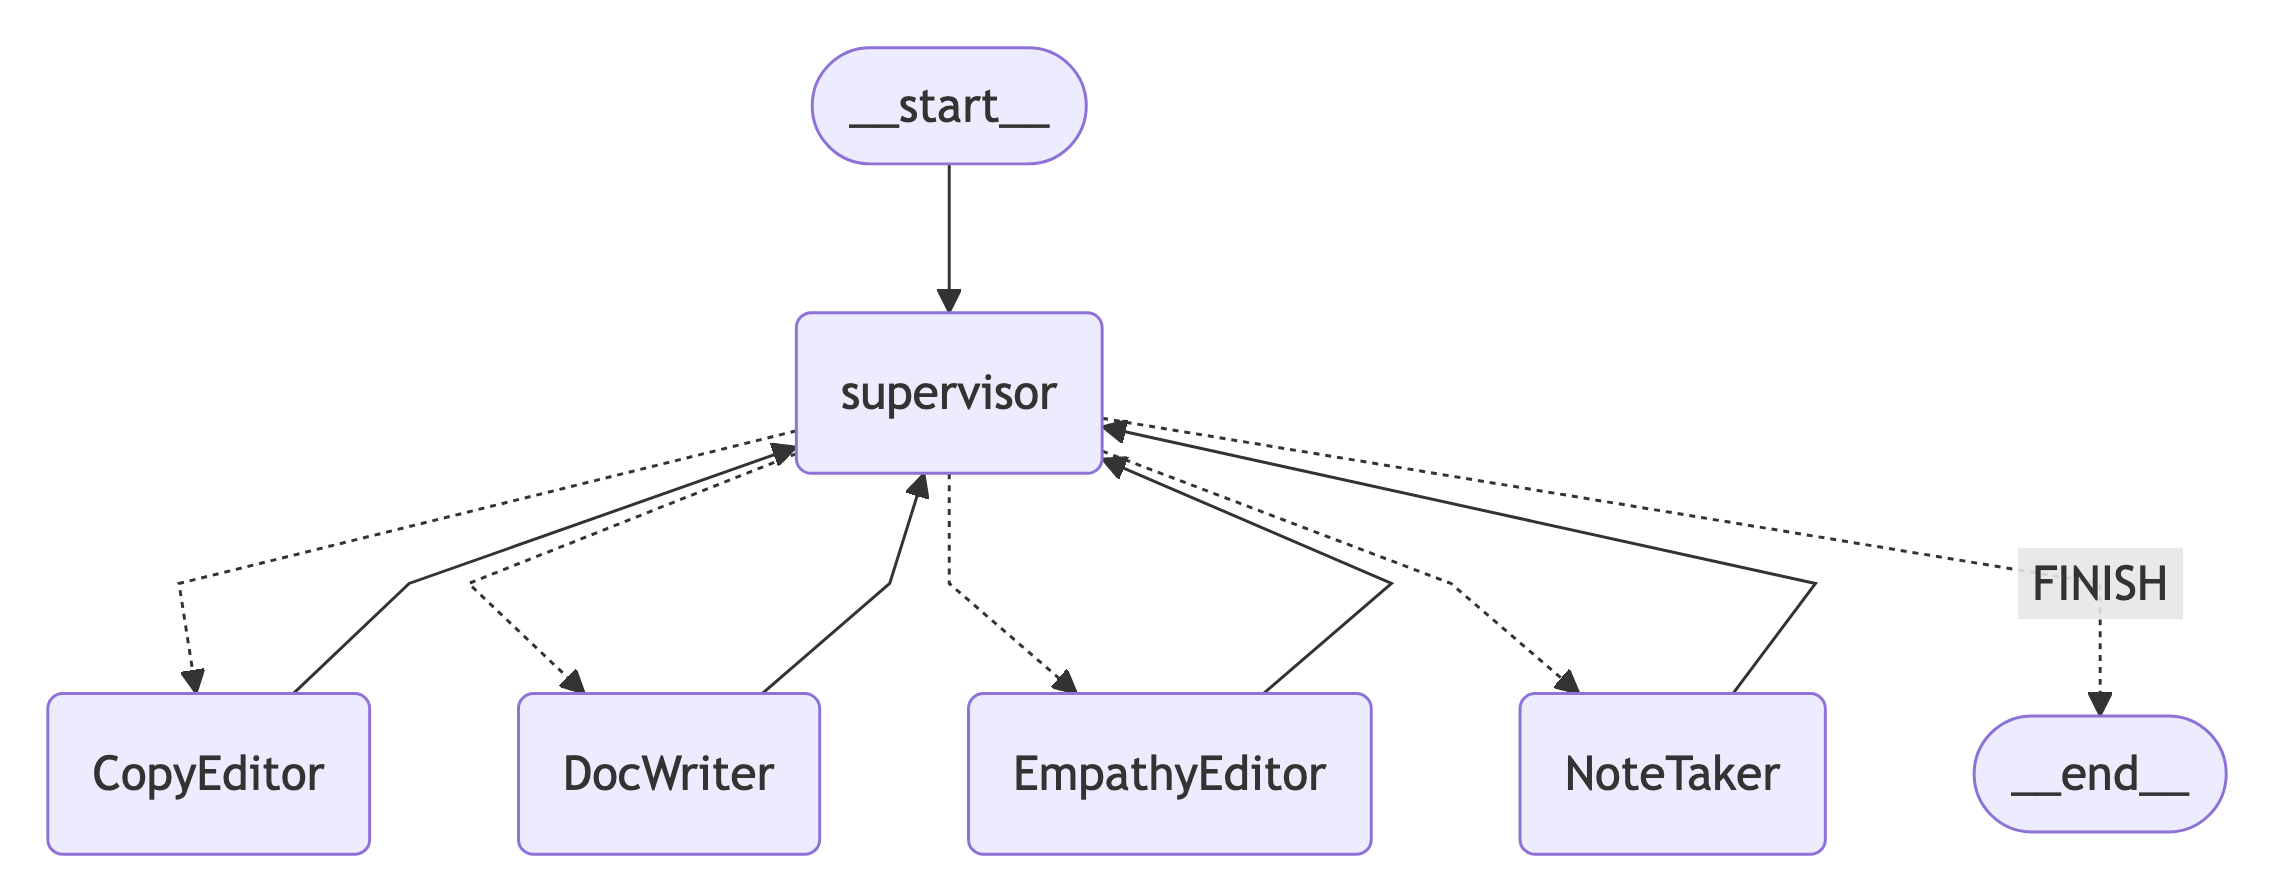

In [142]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [143]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [144]:
for s in authoring_chain.stream(
    "Write a customer assistance response on the positioning of Student Loans as it relates to low income students.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have created a customer assistance response regarding the positioning of student loans as it relates to low-income students. You can access the document [here](sandbox:/Student_Loans_Low_Income_Students_Response.txt). If you need any changes or further assistance, please let me know!', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content="Here is the customer assistance response on the positioning of student loans as it relates to low-income students:\n\n---\n\n**Subject: Understanding Student Loans for Low-Income Students**\n\nDear [Customer's Name],\n\nThank you for reaching out with your inquiry regarding the positioning of student loans in relation to low-income students. We understand that the financing of education can be a significant concern for many, especially for those from low

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [145]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Response team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [146]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [147]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Response team", get_last_message | authoring_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [148]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Response team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Response team": "Response team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [149]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a customer assistance response on the positioning of Student Loans as it relates to low income students. First consult the research team. Then make sure you consult the response team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="Subject: Positioning of Student Loans for Low-Income Students\n\nDear [Customer's Name],\n\nThank you for reaching out to us regarding your concerns about student loans, particularly as they relate to low-income students. We understand that navigating the financial landscape of higher education can be daunting, particularly for those from disadvantaged backgrounds.\n\nIn the current landscape, federal student loans play a crucial role in helping low-income students access higher education. For the 2024-2025 academic year, dependent undergraduate students can borrow up to $5,500 as freshmen, with annual increases based on their year in school. Independent undergraduates, including those whose parents are unable to secure PLUS loans, can borrow even more—starting at $9,500 for freshmen. This tiered structure aims to alleviate some of the financial burdens faced by students from lower-incom

## SAMPLE POST!

**Subject: Assistance Regarding Student Loans for Low-Income Students**

Dear [Customer's Name],

Thank you for reaching out regarding student loans and their implications for low-income students. We understand that navigating the financial aid landscape can be daunting, and we’re here to provide guidance and support.

Student loans are instrumental in granting low-income students access to higher education, especially when scholarships and grants may fall short of covering the full cost of attendance. The federal student loan program presents various options designed to make borrowing more manageable for those in need.

**1. Understanding Loan Types:**
   - **Subsidized Loans**: These loans are available to undergraduate students who demonstrate financial need. The government covers the interest while the borrower is enrolled at least half-time, which can significantly alleviate the overall debt burden upon graduation.
   - **Unsubsidized Loans**: Accessible to both undergraduate and graduate students, these loans do not require a demonstration of financial need. However, interest starts accruing from the moment the loan is disbursed.

**2. Income-Based Repayment Options:**
For low-income borrowers, Income-Based Repayment (IBR) plans can be especially advantageous. These plans ensure that monthly payments are based on income and family size, which helps keep payments manageable. Additionally, after 20-25 years of qualifying payments, any remaining loan balance may be eligible for forgiveness. 

**3. Key Benefits:**
   - **Lower Payments**: IBR plans decrease the monthly payment amount, making it easier for low-income students to manage their loans successfully.
   - **Forgiveness Opportunities**: Those who pursue careers in public service may qualify for further loan forgiveness options.

**4. The Importance of Financial Aid Awareness:**
It is vital for low-income students to be aware of their options concerning financial aid and student loans. We recommend that students and families familiarize themselves with the array of resources available, such as [Federal Student Aid](https://studentaid.gov), which provides comprehensive information on eligibility and application processes.

If you need further assistance or have specific questions, please don’t hesitate to reach out. Our goal is to ensure that every student can pursue their educational aspirations without the fear of overwhelming debt.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  
[Your Organization]